This human-labeled data comes from the [Wiki labels project](https://en.wikipedia.org/wiki/Wikipedia:Labels/About), courtesy of Aaron Halfaker. Specifically, this is a JSON dataset of 20k labeled observations, available [here](https://labels.wmflabs.org/campaigns/enwiki/4/?tasks). 

In [364]:
import pandas as pd
import numpy as np
import json
import mwapi
import re
from bs4 import BeautifulSoup
import geoip2.database
import geocoder
import requests
import p5utils

In [346]:
with open('./labeled_revs.json', 'r') as f:
    labeled_revs = json.load(f)

In [347]:
revs_df = pd.DataFrame(labeled_revs['tasks'])
revs_df.head()

,campaign_id,data,id,labels
0,4,{'rev_id': 644933637},180077,"[{'data': {'automatic': 'advanced-rights', 'da..."
1,4,{'rev_id': 629393521},180078,"[{'data': {'automatic': 'not-reverted', 'damag..."
2,4,{'rev_id': 655365754},180079,"[{'data': {'automatic': 'advanced-rights', 'da..."
3,4,{'rev_id': 616502017},180080,"[{'data': {'automatic': 'not-reverted', 'damag..."
4,4,{'rev_id': 651762922},180081,"[{'data': {'automatic': 'advanced-rights', 'da..."


Looks like we're going to need to do some work de-JSONifying this. Let's take a look at a single 'labels' data point.

In [13]:
revs_df['labels'].iloc[1]

[{'data': {'automatic': 'not-reverted',
   'damaging': False,
   'goodfaith': True,
   'unsure': True},
  'timestamp': 1436918316.99114,
  'user_id': 41948920}]

Aaron warned me that some revisions had two labels; actually, some had as many as four! Let's pull them out into separate columns and drop the additional labels.

In [348]:
revs_df[['labels1', 'labels2', 'labels3', 'labels4']] =\
    pd.DataFrame(revs_df['labels'].values.tolist(), index=revs_df.index)

In [25]:
revs_df = revs_df.drop(['labels', 'labels2', 'labels3', 'labels4'], axis=1)

Time to extract the revision IDs from the 'data' column, and everything else from 'labels1'.

In [52]:
def extract_labels(labels):
    try:
        automatic = labels['data']['automatic']
    except KeyError:
        automatic = None
    damaging = labels['data']['damaging']
    goodfaith = labels['data']['goodfaith']
    try:
        unsure = labels['data']['unsure']
    except KeyError:
        unsure = None
    timestamp = labels['timestamp']
    user_id = labels['user_id']
    return automatic, damaging, goodfaith, unsure, timestamp, user_id

In [30]:
revs_df['rev_id'] = revs_df['data'].map(lambda x: x['rev_id'])

In [351]:
revs_df[['automatic', 'damaging', 'goodfaith', 'unsure', 'timestamp', 'user_id']]\
    = pd.DataFrame(revs_df['labels1'].map(extract_labels).tolist())

Hmm, what's this 'automatic' value? It looks like the 'damaging' value (which is what we care about for our classification) is always False when 'automatic' exists - that is, revisions are automatically scored as not damaging if the editor had advanced rights (i.e., was a Wikipedia moderator/administrator) or if the edit was not reverted.

In [67]:
revs_df['automatic'].value_counts()

advanced-rights    8966
not-reverted       7374
Name: automatic, dtype: int64

In [454]:
revs_df.query('automatic=="not-reverted" & damaging==True')

,campaign_id,data,id,labels,labels1,labels2,labels3,labels4,automatic,damaging,goodfaith,unsure,timestamp,user_id


In terms of damaging/non-damaging, the majority of these 20k cases were actually automatically coded - only about 3,500 of them were actually hand-labeled.

In [100]:
revs_df[revs_df['automatic'].isna()]['damaging'].value_counts()

False    2728
True      804
Name: damaging, dtype: int64

Since we know we only want anonymous (IP address) edits, we can take out all of the advanced-rights cases.

In [109]:
revs_df_noadv = revs_df[revs_df['automatic'] != 'advanced-rights']

Time to get some needed metadata from the Wikipedia API. The `get_metadata` function (see `p5utils.py`) gets various necessary data from the Wikipedia API: the namespace (i.e., whether the edit was to an actual article or something else, like a user page), title, size of page, size of edit, user ID, and the actual text added in the edit (scraped from the diff with Beautiful Soup).

Because the repeated API queries had a tendency to occasionally slow down or break, I gathered the metadata in batches of 2,000 and aggregated.

In [ ]:
session = mwapi.Session('https://en.wikipedia.org', user_agent='aaron')

In [ ]:
metadata_0_1999 =\
    pd.DataFrame(revs_df_noadv[:2000]\
                 .apply(lambda x: p5utils.get_metadata(x['rev_id'], session), axis=1)\
                 .tolist())

In [ ]:
metadata_2000_3999 =\
    pd.DataFrame(revs_df_noadv[2000:4000]\
                 .apply(lambda x: p5utils.get_metadata(x['rev_id'], session), axis=1)\
                 .tolist())

In [ ]:
metadata_4000_5999 =\
    pd.DataFrame(revs_df_noadv[4000:6000]\
                 .apply(lambda x: p5utils.get_metadata(x['rev_id'], session), axis=1)\
                 .tolist())

In [ ]:
metadata_6000_7999 =\
    pd.DataFrame(revs_df_noadv[6000:8000]\
                 .apply(lambda x: p5utils.get_metadata(x['rev_id'], session), axis=1)\
                 .tolist())

In [ ]:
metadata_8000_9999 =\
    pd.DataFrame(revs_df_noadv[8000:10000]\
                 .apply(lambda x: p5utils.get_metadata(x['rev_id'], session), axis=1)\
                 .tolist())

In [ ]:
metadata_10000_end =\
    pd.DataFrame(revs_df_noadv[10000:]\
                 .apply(lambda x: p5utils.get_metadata(x['rev_id'], session), axis=1)\
                 .tolist())

In [195]:
metadata = pd.concat([metadata_0_1999,
                      metadata_2000_3999,
                      metadata_4000_5999,
                      metadata_6000_7999,
                      metadata_8000_9999,
                      metadata_10000_end]).reset_index(drop=True)

metadata.columns = ['namespace', 'title', 'fromsize', 'tosize', 'user', 'additions']

Merging in our metadata.

In [188]:
revs_df_noadv = revs_df_noadv.reset_index(drop=True)

In [199]:
labeled = revs_df_noadv.join(metadata)

We only want edits to Wikipedia articles, not talk pages etc.

In [228]:
labeled = labeled.query('namespace == 0.0')

We also only want anonymous edits (that is, from IP addresses instead of usernames). This regex will include invalid IPs like 821.481.317.499 but I'm not too worried about that here. Since this data is from 2014/2015, there are no IPv6 formatted addresses to worry about.

In [231]:
def is_anon(user):
    if re.match('^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$', user):
        return True
    else:
        return False

In [232]:
labeled['anon_user'] = labeled['user'].map(is_anon)

In [235]:
labeled_anon = labeled[labeled['anon_user']]

Down to just over 3,000 edits, from our original 20,000. Oh well!

In [236]:
len(labeled_anon)

3178

In [239]:
labeled_anon['damaging'].value_counts(normalize=True)

False    0.855591
True     0.144409
Name: damaging, dtype: float64

In [242]:
labeled_anon = labeled_anon.drop(['campaign_id', 'namespace', 'anon_user'], axis=1)

`geocode_ips` uses the GeoLite2 database to assign locations based on IPs.

In [254]:
labeled_anon = p5utils.geocode_ips(labeled_anon, 'user')

Use geocoder for the handful of IPs where GeoLite2 didn't work.

In [271]:
for ip in labeled_anon[labeled_anon['lat'].isna()]['user']:
    g = geocoder.ip(ip)
    labeled_anon.loc[labeled_anon['user']==ip, 'lat'] = g.lat
    labeled_anon.loc[labeled_anon['user']==ip, 'lng'] = g.lng
    labeled_anon.loc[labeled_anon['user']==ip, 'city'] = g.city
    labeled_anon.loc[labeled_anon['user']==ip, 'state'] = g.state
#     labeled_anon.loc[labeled_anon['actor_name']==ip, 'country'] = 'United States'
    labeled_anon.loc[labeled_anon['user']==ip, 'country_iso'] = g.country

In [275]:
for ip in labeled_anon[labeled_anon['country'].isna()]['user']:
    g = geocoder.ip(ip)
    labeled_anon.loc[labeled_anon['user']==ip, 'lat'] = g.lat
    labeled_anon.loc[labeled_anon['user']==ip, 'lng'] = g.lng
    labeled_anon.loc[labeled_anon['user']==ip, 'city'] = g.city
    labeled_anon.loc[labeled_anon['user']==ip, 'state'] = g.state
#     labeled_anon.loc[labeled_anon['actor_name']==ip, 'country'] = 'United States'
    labeled_anon.loc[labeled_anon['user']==ip, 'country_iso'] = g.country

Getting ORES data from the API took only a few minutes using 50-revision batches.

In [312]:
revision_chunks = np.array_split(labeled_anon['rev_id'], len(labeled_anon)//50)

In [324]:
ores_dfs = []
for i, chunk in enumerate(revision_chunks):
    print(f"getting chunk number {i}...")
    session = requests.Session()
    df = p5utils.get_ores_data(chunk, session)
    ores_dfs.append(df)

getting chunk number 0...
getting chunk number 1...
getting chunk number 2...
getting chunk number 3...
getting chunk number 4...
getting chunk number 5...
getting chunk number 6...
getting chunk number 7...
getting chunk number 8...
getting chunk number 9...
getting chunk number 10...
getting chunk number 11...
getting chunk number 12...
getting chunk number 13...
getting chunk number 14...
getting chunk number 15...
getting chunk number 16...
getting chunk number 17...
getting chunk number 18...
getting chunk number 19...
getting chunk number 20...
getting chunk number 21...
getting chunk number 22...
getting chunk number 23...
getting chunk number 24...
getting chunk number 25...
getting chunk number 26...
getting chunk number 27...
getting chunk number 28...
getting chunk number 29...
getting chunk number 30...
getting chunk number 31...
getting chunk number 32...
getting chunk number 33...
getting chunk number 34...
getting chunk number 35...
getting chunk number 36...
getting chu

In [328]:
ores_data = pd.concat(ores_dfs)

In [330]:
ores_data['rev_id'] = ores_data['rev_id'].map(int)

In [335]:
labeled_ores = pd.merge(labeled_anon, ores_data, on='rev_id')

Let's see how ORES does separating the damaging and non-damaging edits. 

In [339]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

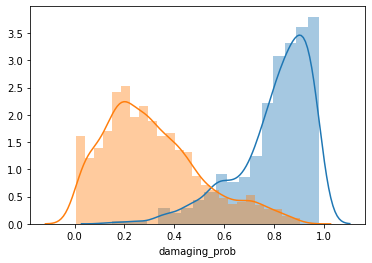

In [342]:
sns.distplot(labeled_ores.query('damaging==True')['damaging_prob'])
sns.distplot(labeled_ores.query('damaging==False')['damaging_prob'])

Since it was literally trained on this data, it does unfairly well. Now that we have our labeled test data ready to go, let's pickle it for later.

In [ ]:
import pickle
with open('./labeled_ores.pkl', 'wb') as f:
    pickle.dump(labeled_ores, f)